## Importing libraries and seeding for reproducibility

In [1]:
import random
import numpy as np
import torch

def seed_everything(seed=42):
    """
    Ensures reproducibility across Python, NumPy, and PyTorch.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # deterministic results - slightly slower, but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

g = torch.Generator().manual_seed(42) # for data loaders

In [2]:
#importing all the necessary libraries 
import pandas as pd
import seaborn as sns
import numpy as np
import pyreadr as py # library to read .Rdata files in python
import sqlite3
import os
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,Normalizer, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
from torch.optim.lr_scheduler import CosineAnnealingLR

## Data loading and preprocessing

### Load data

In [4]:
train_ss = pd.read_csv('semi_supervised_train_new.csv')
val_ss = pd.read_csv("semi_supervised_val_new.csv")
test_ss = pd.read_csv("supervised_test_new.csv")

In [5]:
print("Shape of the sampled train data:", train_ss.shape)
print("Shape of the sampled test data:", test_ss.shape)
print("Shape of the sampled CV data:", val_ss.shape)

Shape of the sampled train data: (160000, 57)
Shape of the sampled test data: (434400, 57)
Shape of the sampled CV data: (80000, 57)


### Scaling

In [6]:
features = [col for col in train_ss.columns if 'xmeas' in col or 'xmv' in col]
target = 'faultNumber'

scaler = StandardScaler()
train_c = train_ss.copy()
val_c = val_ss.copy()
test_c = test_ss.copy()

In [7]:
train_c[features] = scaler.fit_transform(train_c[features])
val_c[features] = scaler.transform(val_c[features])
test_c[features] = scaler.transform(test_c[features])

### Creating sequences

In [ ]:
class SequenceDataset(Dataset):
    """
    Sliding windows per trajectory (grouped by run_col, default='traj_key').

    For AE:
      label_sequences = False -> returns (x, x)
      label_sequences = True  -> returns (x, x, y) with binary y from last frame.
    """
    def __init__(self, df, features, seq_len, label_sequences: bool, run_col="traj_key"):
        self.features = features
        self.seq_len = seq_len
        self.label_sequences = label_sequences
        self.run_col = run_col

        X, y = [], []

        # sort by trajectory + time, same as supervised
        df = df.sort_values([run_col, "sample"]).reset_index(drop=True)

        # build windows within each trajectory
        for traj_id, g in df.groupby(run_col):
            g = g.reset_index(drop=True)
            n = len(g)
            if n < seq_len:
                continue

            vals   = g[features].values
            faults = g["faultNumber"].values

            for i in range(n - seq_len + 1):
                X.append(vals[i:i+seq_len])

                if self.label_sequences:
                    last_fault = faults[i + seq_len - 1]
                    y.append(1 if last_fault != 0 else 0)

        self.X = torch.tensor(np.array(X), dtype=torch.float32)
        self.y = (
            torch.tensor(np.array(y), dtype=torch.long)
            if self.label_sequences else None
        )

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.label_sequences:
            return self.X[idx], self.X[idx], self.y[idx]   # (x, x, y)
        return self.X[idx], self.X[idx]                    # (x, x)


In [9]:
seq_len = 30

train_dataset = SequenceDataset(
    train_c,
    features=features,
    seq_len=seq_len,
    label_sequences=False,
    run_col="traj_key",         
)

val_dataset = SequenceDataset(
    val_c,
    features=features,
    seq_len=seq_len,
    label_sequences=False,
    run_col="traj_key",
)

test_dataset = SequenceDataset(
    test_c,                      
    features=features,
    seq_len=seq_len,
    label_sequences=True,        
    run_col="traj_key",
)


### Data loading in batches 

In [10]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,  drop_last=False, generator=g)
val_loader   = DataLoader(val_dataset,   batch_size=128, shuffle=False, drop_last=False, generator=g)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, drop_last=False, generator=g)


### Using GPU

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Model Architecture and Training

### Create a model

In [12]:
class ConvAuto(nn.Module):
    def __init__(self, input_dim, seq_len, ff_dim=32, nhead=4, dropout=0.05):
        super().__init__()
        # CNN Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Transformer Layer
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=128, nhead=nhead, dim_feedforward=ff_dim, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=1)

        # CNN Decoder
        self.decoder = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=input_dim, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # Input shape: (batch, seq_len, features)
        x = x.permute(0, 2, 1)  # (batch, features, seq_len) for Conv1D
        x = self.encoder(x)     # (batch, 128, seq_len)
        x = x.permute(0, 2, 1)  # (batch, seq_len, 128) for Transformer
        x = self.transformer(x) # (batch, seq_len, 128)
        x = x.permute(0, 2, 1)  # (batch, 128, seq_len) for Conv1D
        x = self.decoder(x)     # (batch, features, seq_len)
        x = x.permute(0, 2, 1)  # (batch, seq_len, features)
        return x


### Moving model to device

In [ ]:
model = ConvAuto(input_dim=len(features), seq_len=seq_len)
model.to(device)

ConvAuto(
  (encoder): Sequential(
    (0): Conv1d(52, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
  )
  (transformer_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=32, bias=True)
    (dropout): Dropout(p=0.05, inplace=False)
    (linear2): Linear(in_features=32, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.05, inplace=False)
    (dropout2): Dropout(p=0.05, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLine

### Model Training

In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)
grad_clip = 1.0
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

In [15]:
def train_ae(model, train_loader, val_loader, epochs):
    device = next(model.parameters()).device
    train_losses, val_losses = [], []
    best_val, best_state, wait, patience = float('inf'), None, 0, 10

    for epoch in range(epochs):
        # training
        model.train()
        tr_sum, tr_n = 0.0, 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            bs = x_batch.size(0)
            tr_sum += loss.item() * bs
            tr_n   += bs
        avg_train_loss = tr_sum / max(1, tr_n)
        train_losses.append(avg_train_loss)

        # validation
        model.eval()
        va_sum, va_n = 0.0, 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                outputs = model(x_val)
                loss = criterion(outputs, y_val)
                bs = x_val.size(0)
                va_sum += loss.item() * bs
                va_n   += bs
        avg_val_loss = va_sum / max(1, va_n)
        val_losses.append(avg_val_loss)

        scheduler.step()
        print(f"Epoch {epoch+1:02d}/{epochs} | Train {avg_train_loss:.6f} | Val {avg_val_loss:.6f} | LR {scheduler.get_last_lr()[0]:.5g}")

        # early stopping to avoid overfitting 
        if avg_val_loss + 1e-8 < best_val:
            best_val, best_state, wait = avg_val_loss, {k: v.detach().cpu() for k,v in model.state_dict().items()}, 0
        else:
            wait += 1
            if wait >= patience: 
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch 01/50 | Train 0.112893 | Val 0.017278 | LR 0.00049951
Epoch 02/50 | Train 0.012569 | Val 0.007713 | LR 0.00049803
Epoch 03/50 | Train 0.006676 | Val 0.005666 | LR 0.00049558
Epoch 04/50 | Train 0.004538 | Val 0.004639 | LR 0.00049216
Epoch 05/50 | Train 0.003382 | Val 0.003650 | LR 0.00048779
Epoch 06/50 | Train 0.002696 | Val 0.002840 | LR 0.00048248
Epoch 07/50 | Train 0.002274 | Val 0.001714 | LR 0.00047625
Epoch 08/50 | Train 0.001948 | Val 0.001757 | LR 0.00046914
Epoch 09/50 | Train 0.001737 | Val 0.001820 | LR 0.00046116
Epoch 10/50 | Train 0.001581 | Val 0.001268 | LR 0.00045235
Epoch 11/50 | Train 0.001399 | Val 0.001393 | LR 0.00044274
Epoch 12/50 | Train 0.001298 | Val 0.001052 | LR 0.00043238
Epoch 13/50 | Train 0.001170 | Val 0.001289 | LR 0.00042129
Epoch 14/50 | Train 0.001105 | Val 0.001200 | LR 0.00040954
Epoch 15/50 | Train 0.001018 | Val 0.000760 | LR 0.00039715
Epoch 16/50 | Train 0.000884 | Val 0.001713 | LR 0.00038419
Epoch 17/50 | Train 0.000851 | Val 0.001

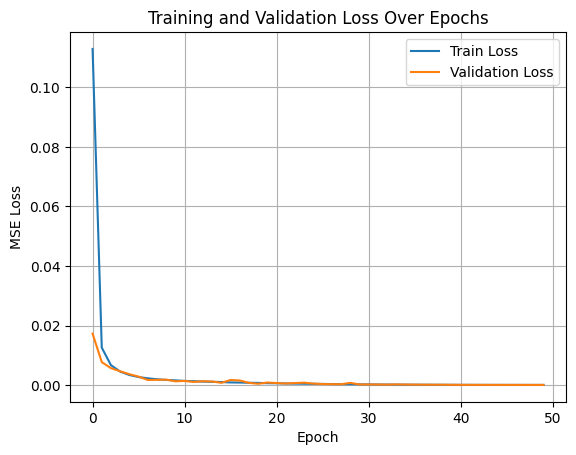

In [16]:
epochs = 50
train_ae(model, train_loader, val_loader, epochs)

## Model Evaluation

### Reconstruction Loss

In [17]:
def get_reconstruction_errors(model, data_loader, has_labels=False):
    model.eval()
    errors = []
    true_labels = []
    inputs = []
    recons = []

    with torch.no_grad():
        for batch in data_loader:
            if has_labels:
                x_batch, _, label_batch = batch
            else:
                x_batch, _ = batch
                label_batch = None

            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            loss = torch.mean((outputs - x_batch) ** 2, dim=(1, 2))  # MSE per sequence
            errors.extend(loss.cpu().numpy())
            inputs.extend(x_batch.cpu().numpy())
            recons.extend(outputs.cpu().numpy())

            if label_batch is not None:
                true_labels.extend(label_batch.numpy())

    return np.array(errors), np.array(true_labels), np.array(inputs), np.array(recons)


In [18]:
val_errors, val_labels, _, _ = get_reconstruction_errors(model, val_loader)

### Percentile-based thresholding

In [19]:
# choose percentile
PERCENTILE = 99.5   

threshold = np.percentile(val_errors, PERCENTILE)
print(f"Threshold based on {PERCENTILE}th percentile of validation errors: {threshold:.4f}")


Threshold based on 99.5th percentile of validation errors: 0.0004


### Getting test results

In [20]:
test_errors, test_labels, test_inputs, test_recons = get_reconstruction_errors(model, test_loader, has_labels=True)
y_pred = (test_errors > threshold).astype(int)

In [21]:
print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred))

print("\nClassification Report:")
print(classification_report(test_labels, y_pred, target_names=['Normal', 'Faulty'], digits=5))


Confusion Matrix:
[[222725    715]
 [  6540 190065]]

Classification Report:
              precision    recall  f1-score   support

      Normal    0.97147   0.99680   0.98397    223440
      Faulty    0.99625   0.96674   0.98127    196605

    accuracy                        0.98273    420045
   macro avg    0.98386   0.98177   0.98262    420045
weighted avg    0.98307   0.98273   0.98271    420045



## Visualization

In [ ]:
def visualize_overlay_by_category(errors, labels, inputs, recons, threshold, feature_index=0):

    preds = (errors >= threshold).astype(int)
    y_true = (np.array(labels) != 0).astype(int)

    # indices per confusion category
    categories = {
        "True Normal → Pred Normal": np.where((y_true == 0) & (preds == 0))[0],
        "True Normal → Pred Fault":  np.where((y_true == 0) & (preds == 1))[0],
        "True Fault → Pred Normal":  np.where((y_true == 1) & (preds == 0))[0],
        "True Fault → Pred Fault":   np.where((y_true == 1) & (preds == 1))[0],
    }

    fig, axes = plt.subplots(2, 2, figsize=(13, 7))
    fig.suptitle("Autoencoder Classification Outcomes", fontsize=16, fontweight='bold')

    for ax, (title, idxs) in zip(axes.flat, categories.items()):
        if len(idxs) == 0:
            ax.axis('off')
            ax.set_title(f"{title}\n(No samples)")
            continue

        # choosing representative sample (median error)
        i = idxs[np.argsort(errors[idxs])[len(idxs)//2]]
        orig = inputs[i][:, feature_index]
        recon = recons[i][:, feature_index]
        err_t = np.abs(orig - recon)

        ax.plot(orig, label='Original', color='steelblue', alpha=0.9)
        ax.plot(recon, '--', label='Reconstructed', color='orange', alpha=0.9)
        ax.fill_between(np.arange(len(err_t)), orig, recon, color='red', alpha=0.25)
        ax.set_title(f"{title}\nMeanErr={err_t.mean():.3f}, MaxErr={err_t.max():.3f}")
        ax.set_xlabel("Timestep")
        ax.set_ylabel(f"Feature {feature_index}")
        ax.grid(True)

    handles, labels_legend = ax.get_legend_handles_labels()
    fig.legend(handles, labels_legend, loc='lower center', ncol=3, frameon=False)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


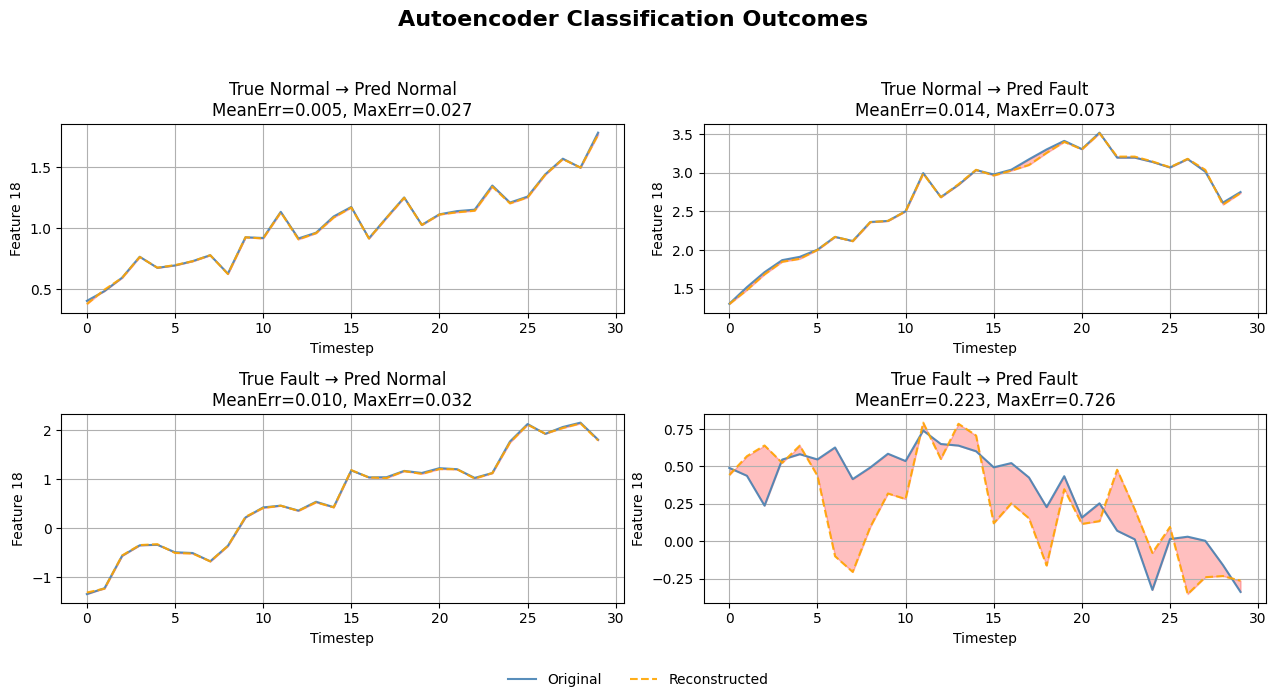

In [25]:
visualize_overlay_by_category(test_errors, test_labels, test_inputs, test_recons,threshold, feature_index=18)